# Table of Content
* [Read-CSV](#Read-CSV)
* [Categorical-variables-handling](#Categorical-variables-handling)
* [Numeric-variables-handing](#Numeric-variables-handing)
* [Pipeline-to-process-all-variables](#Pipeline-to-process-all-variables)
* [Create-features-and-label](#Create-features-and-label)
* [Split-training-set-and-test-set](#Split-training-set-and-test-set)
* [Generic-Modelling-Fuction](#Generic-Modelling-Fuction)
* [Logistic-Regression-fitting](#Logistic-Regression-fitting)
  * [Training-Summary](#Training-Summary)
  * [Prediction-on-test-set](#Prediction-on-test-set)
  * [Evaluation](#Evaluation)
* [Decision-Tree-fitting](#Decision-Tree-fitting)
* [Random-Forest-fitting](#Random-Forest-fitting)
* [Compare-3-models](#Compare-3-models)
* [Inspect-Logistic-Regression-Model-Coefficients](#Inspect-Logistic-Regression-Model-Coefficients)
  * [Get-coefficient-vector-from-logistic-regression-model](#Get-coefficient-vector-from-logistic-regression-model)
  * [Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients](#Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients)
  * [Look-at-how-the-feature-vector-been-created](#Look-at-how-the-feature-vector-been-created)
  * [Using-onle-emp_title-for-training](#Using-onle-emp_title-for-training)
  * [Observation](#Observation)

In [178]:
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.sql._

import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}

import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.sql._
import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}


# Read CSV

Also invert the label
* 1: bad loan
* 0: good loan

In [140]:
val invertLabel = udf((v: Int) => v match {
    case 0 => 1
    case 1 => 0
})

invertLabel: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [141]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan_Wrangled.csv")
  .withColumn("loan_status",invertLabel($"loan_status"))

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 63 more fields]


# Categorical variables handling

In [142]:
val categoricalColumns = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

categoricalColumns: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type)


In [143]:
val categoricalFeatures = categoricalColumns.flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...


# Numeric variables handing

In [144]:
val numericColumns = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)
                    .filterNot( c => c == "loan_status" )

numericColumns: Array[String] = Array(loan_amnt, int_rate, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, total_pymnt, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_rev_tl, num_bc_sats, num_il_tl, num_rev_accts, num_sats, num_tl_120dpd_2m, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_il_high_credit_limit)


In [145]:
val numericColumnsAssembler = new VectorAssembler()
  .setInputCols(numericColumns)
  .setOutputCol("numerical_features")

numericColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_6fc74515a96f


In [146]:
val numericColumnsScaler = new StandardScaler()
      .setInputCol("numerical_features")
      .setOutputCol("numerical_features" + "_vec")
      .setWithStd(true)
      .setWithMean(true)

numericColumnsScaler: org.apache.spark.ml.feature.StandardScaler = stdScal_ee53836da63d


In [147]:
categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler)

res57: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(strIdx_aade2de7aa95, oneHotEncoder_1a31a11dd8cd, strIdx_a7175e751545, oneHotEncoder_a9dbad5cbb39, strIdx_320a6153ce36, oneHotEncoder_99a6e295fad5, strIdx_deb7cddce7f2, oneHotEncoder_48948b9ea42d, strIdx_a7fce7b7908b, oneHotEncoder_9fc7660e8e45, strIdx_af546bc9f2c2, oneHotEncoder_3aae1ea73550, strIdx_7c640534197c, oneHotEncoder_46a30eaae288, strIdx_7e6aebadc6cc, oneHotEncoder_37557f7842f6, strIdx_b27471ff96...

# Pipeline to process all variables

In [148]:
val pipeline = new Pipeline()
  .setStages(categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler) )

val df_transformed = pipeline
  .fit(df)
  .transform(df)

pipeline: org.apache.spark.ml.Pipeline = pipeline_bc592b214658
df_transformed: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 99 more fields]


# Create features and label

In [149]:
val featureColumns = df_transformed.columns.filter(_.contains("_vec"))

featureColumns: Array[String] = Array(term_vec, grade_vec, sub_grade_vec, emp_title_vec, emp_length_vec, home_ownership_vec, verification_status_vec, issue_d_vec, purpose_vec, title_vec, zip_code_vec, addr_state_vec, earliest_cr_line_vec, initial_list_status_vec, last_pymnt_d_vec, last_credit_pull_d_vec, application_type_vec, numerical_features_vec)


In [150]:
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(featureColumns)
  .setOutputCol("features")

val df_input = featureColumnsAssembler.transform(df_transformed).withColumn("label",col("loan_status"))

featureColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_c5e3bd5601e6
df_input: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 101 more fields]


# Split training set and test set

In [151]:
val Array(trainingData, testData) = df_input.randomSplit(Array(0.8, 0.2), seed = 1234L)

trainingData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]
testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]


In [152]:
testData.count

res58: Long = 3967


In [153]:
trainingData.count

res59: Long = 16103


# Generic Modelling Fuction
The function will accept inputs to determine the appropriate Models, options are:
* logistic regression
* decision tree
* random forest

In [212]:
def runModel (df: DataFrame, 
              modelType: String, 
              threshold: Double = 0.5, 
              weighted: Boolean = false,
              maxIter: Int = 10,
              regParam: Double = 0.0) : PipelineModel = {
        
    val pipelineOrder: Array[org.apache.spark.ml.PipelineStage] = 
    
    //depending on the model chosen,
    if (modelType == "lr"){
        //logistic regression option
        Array(
            new LogisticRegression()
                .setMaxIter(maxIter)
                .setRegParam(regParam)
                .setThreshold(threshold)
              )
    }
    else if (modelType == "dt"){
        //decision tree option
        Array(
            new DecisionTreeClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
              )
    }
    else if (modelType == "rf"){
        //random forest option
        Array(
            new RandomForestClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
        )
    }
    else {
        Array[org.apache.spark.ml.PipelineStage]()
    }    

    //set the pipeline for the model
    val pipeline = new Pipeline()
        .setStages(pipelineOrder)
    
    //return a model fitted on the dataframe
    return pipeline.fit(df)
}

runModel: (df: org.apache.spark.sql.DataFrame, modelType: String, threshold: Double, weighted: Boolean, maxIter: Int, regParam: Double)org.apache.spark.ml.PipelineModel


# Logistic Regression fitting

In [213]:
// Fit the logistic regression model 
val lr = runModel(trainingData,"lr")

lr: org.apache.spark.ml.PipelineModel = pipeline_432ba0605a6f


In [214]:
val lrModel = lr.stages(new_lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_9bd96f7fca84, numClasses = 2, numFeatures = 10856


## Training Summary

In [215]:
// Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
// example
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")

Accuracy: 0.9985716947152704
FPR: 0.006570839593664054
TPR: 0.9985716947152705
F-measure: 0.9985715040034712
Precision: 0.9985713340480937
Recall: 0.9985716947152705


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@a8ea413
accuracy: Double = 0.9985716947152704
falsePositiveRate: Double = 0.006570839593664054
truePositiveRate: Double = 0.9985716947152705
fMeasure: Double = 0.9985715040034712
precision: Double = 0.9985713340480937
recall: Double = 0.9985716947152705


In [216]:
val roc = trainingSummary.roc
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.10313630880579011|
|                 0.0|0.19963811821471653|
|                 0.0|0.29613992762364294|
|                 0.0| 0.3926417370325694|
|                 0.0|0.48914354644149577|
|                 0.0| 0.5856453558504222|
|                 0.0| 0.6821471652593486|
|6.922810661128418E-5| 0.7780458383594693|
|6.922810661128418E-5| 0.8745476477683957|
|1.384562132225683...| 0.9704463208685162|
|0.008168916580131533|  0.996984318455971|
|0.019106957424714435| 0.9981905910735827|
|0.030114226375908618| 0.9987937273823885|
| 0.04119072343371409| 0.9987937273823885|
| 0.05219799238490827| 0.9993968636911942|
| 0.06327448944271374| 0.9993968636911942|
| 0.07428175839390792|                1.0|
|  0.0853582554517134|                1.0|
| 0.09643475250951887|                1.0|
+----------

roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]


In [217]:
roc.createOrReplaceTempView("roc")

In [20]:
! pip install pandas
! pip install matplotlib

     |################################| 10.1MB 27.6MB/s eta 0:00:01
     |################################| 512kB 62.6MB/s eta 0:00:01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |################################| 13.1MB 21.2MB/s eta 0:00:01
     |################################| 92kB 29.2MB/s eta 0:00:01
     |################################| 71kB 29.5MB/s eta 0:00:01


   FPR       TPR
0  0.0  0.000000
1  0.0  0.103136
2  0.0  0.199638
3  0.0  0.296140
4  0.0  0.392642


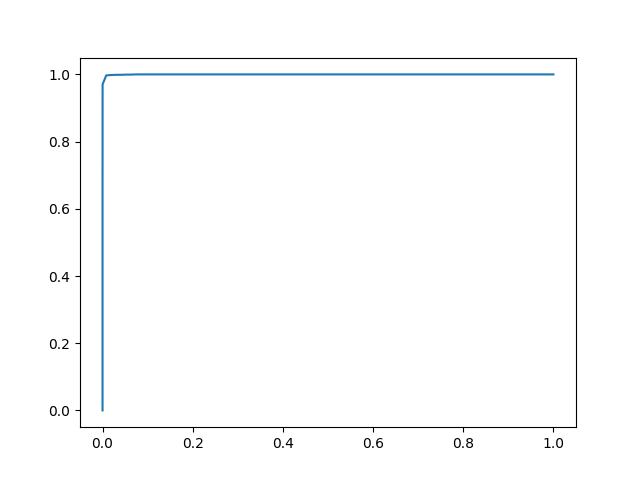

In [218]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Evaluation

In [198]:
def evaluatePrediction(prediction: DataFrame) = {
    prediction.createOrReplaceTempView("prediction")
    
    spark.sql("""
select label,prediction,count(1) from prediction group by label,prediction
""").show(false)
    
    spark.sql("""
select 
round((TP+TN)/(P+N),2) as Accuracy,
round(TP/(TP+FP),2) as Precision,
round(TP/(TP+FN),2) as Recall,
round(2*TP/(2*TP+FP+FN),2) as F1,
round(TP/P,2) as TPR,
round(FP/P,2) as FPR,
round(TN/N,2) as TNR,
round(FN/N,2) as FNR
from (
    select 
    count(1) as total, 
    sum(case when label = 1 and prediction = 1 then 1 else 0 end) as TP,
    sum(case when label = 0 and prediction = 0 then 1 else 0 end) as TN,
    sum(case when label = 0 and prediction = 1 then 1 else 0 end) as FP,
    sum(case when label = 1 and prediction = 0 then 1 else 0 end) as FN,
    sum(case when label = 1 then 1 else 0 end) as P,
    sum(case when label = 0 then 1 else 0 end) as N
    from prediction
    )
""").show(false)
}

evaluatePrediction: (prediction: org.apache.spark.sql.DataFrame)Unit


## Prediction on test set

In [219]:
val prediction = lrModel.transform(testData)
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |149     |
|0    |0.0       |3429    |
|1    |1.0       |279     |
|0    |1.0       |110     |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.93    |0.72     |0.65  |0.68|0.65|0.26|0.97|0.04|
+--------+---------+------+----+----+----+----+----+



prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


# Decision Tree fitting

In [200]:
// fitting decision tree model
val dt = runModel(trainingData,"dt")

val model = dt.stages(dt.stages.length-1).asInstanceOf[DecisionTreeClassificationModel]
val prediction = model.transform(testData)

2019-06-09 04:30:45,512 WARN  [Executor task launch worker for task 5125] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2969_1 in memory! (computed 140.4 MB so far)
2019-06-09 04:30:45,513 WARN  [Executor task launch worker for task 5125] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2969_1 to disk instead.
2019-06-09 04:30:48,519 WARN  [Executor task launch worker for task 5124] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2969_0 in memory! (computed 210.9 MB so far)
2019-06-09 04:30:48,519 WARN  [Executor task launch worker for task 5124] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2969_0 to disk instead.
2019-06-09 04:30:49,627 WARN  [Executor task launch worker for task 5125] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2969_1 in memory! (computed 210.9 MB so far)
2019-06-09 04:30:52,588 WARN  [Executor task launch

dt: org.apache.spark.ml.PipelineModel = pipeline_f81acbabedd0
model: org.apache.spark.ml.classification.DecisionTreeClassificationModel = DecisionTreeClassificationModel (uid=dtc_cb438767e8fa) of depth 5 with 27 nodes
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [201]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |59      |
|0    |0.0       |3477    |
|1    |1.0       |369     |
|0    |1.0       |62      |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.97    |0.86     |0.86  |0.86|0.86|0.14|0.98|0.02|
+--------+---------+------+----+----+----+----+----+



# Random Forest fitting

In [202]:
// fitting random forest model
val rf = runModel(trainingData,"rf")

val model = rf.stages(rf.stages.length-1).asInstanceOf[RandomForestClassificationModel]
val prediction = model.transform(testData)

2019-06-09 04:31:38,469 WARN  [Executor task launch worker for task 5360] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3102_1 in memory! (computed 140.9 MB so far)
2019-06-09 04:31:38,469 WARN  [Executor task launch worker for task 5360] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_3102_1 to disk instead.
2019-06-09 04:31:41,173 WARN  [Executor task launch worker for task 5359] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3102_0 in memory! (computed 211.6 MB so far)
2019-06-09 04:31:41,173 WARN  [Executor task launch worker for task 5359] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_3102_0 to disk instead.
2019-06-09 04:31:42,421 WARN  [Executor task launch worker for task 5360] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3102_1 in memory! (computed 211.6 MB so far)
2019-06-09 04:31:45,759 WARN  [Executor task launch

rf: org.apache.spark.ml.PipelineModel = pipeline_554a6f325386
model: org.apache.spark.ml.classification.RandomForestClassificationModel = RandomForestClassificationModel (uid=rfc_df13c8889b4b) with 20 trees
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [203]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |428     |
|0    |0.0       |3539    |
+-----+----------+--------+

+--------+---------+------+---+---+---+---+----+
|Accuracy|Precision|Recall|F1 |TPR|FPR|TNR|FNR |
+--------+---------+------+---+---+---+---+----+
|0.89    |null     |0.0   |0.0|0.0|0.0|1.0|0.12|
+--------+---------+------+---+---+---+---+----+



# Compare 3 models

| Model| Accuracy | Precision | Recall | F1 | TPR | FPR | TNR | FNR |
|------|------|------|------|------|------|------|------|------|
|   logistic  | 0.93    |0.72     |0.65  |0.68|0.65|0.26|0.97|0.04|
|   decision tree | 0.97    |0.86     |0.86  |0.86|0.86|0.14|0.98|0.02|
|   random forest | 0.89    |0     |0.0   |0.0|0.0|0.0|1.0|0.12|

# Inspect Logistic Regression Model Coefficients

## Get coefficient vector from logistic regression model

In [220]:
val coefficients = lrModel.coefficients.toArray.toList.toDF("coeff")

coefficients: org.apache.spark.sql.DataFrame = [coeff: double]


In [221]:
coefficients.describe().show()

+-------+-------------------+
|summary|              coeff|
+-------+-------------------+
|  count|              10856|
|   mean|-0.5439098696228306|
| stddev|  4.289252199293298|
|    min|-25.490231210213928|
|    max| 33.813368497639075|
+-------+-------------------+



In [222]:
coefficients.createOrReplaceTempView("coeff")

      coeff
0 -0.583154
1 -0.093431
2  0.000000
3 -0.013596
4 -0.400551


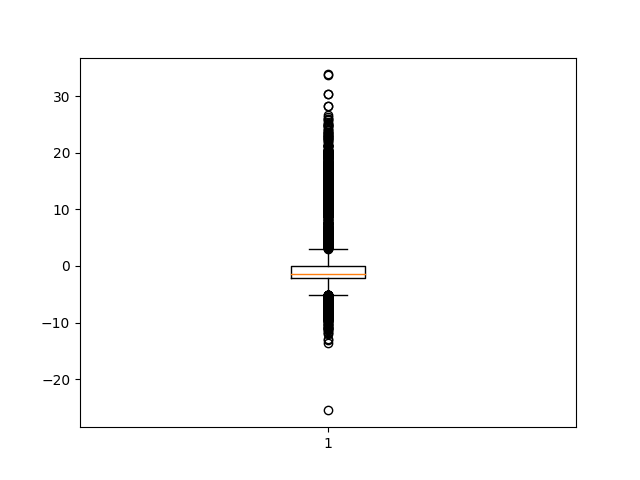

In [223]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

coeff = spark.sql("select * from coeff")
coeffPandas = coeff.toPandas()
print(coeffPandas.head())
plt.clf()
plt.boxplot(coeffPandas['coeff'])
# plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [224]:
coefficients.orderBy(desc("coeff")).show(10)

+------------------+
|             coeff|
+------------------+
|33.813368497639075|
| 33.65072471496433|
|  30.4135332281183|
| 30.40365343637535|
|28.275282727692524|
|28.176961573033108|
| 26.69809917500336|
|26.280674869143354|
| 25.97292200586868|
| 25.86774631152381|
+------------------+
only showing top 10 rows



In [225]:
coefficients.orderBy(asc("coeff")).show(10)

+-------------------+
|              coeff|
+-------------------+
|-25.490231210213928|
|-13.572545915678091|
| -13.00281014951679|
|-12.863165758653262|
|-11.984210644352753|
|-11.817932551974218|
|-11.596705235984121|
|-11.341870123541144|
| -11.33521945458005|
|-11.167556597043053|
+-------------------+
only showing top 10 rows



## Look for the feature vector indexes of 10 largest and smallest coefficients


In [236]:
val coefficientsArr = lrModel.coefficients.toArray

coefficientsArr: Array[Double] = Array(-0.5831544260438446, -0.09343093897890228, 0.0, -0.013596155355772173, -0.40055117879549546, -0.6596497812765124, 0.3413068493139472, 0.3495310764739197, -0.5081591257961061, 0.5171841899053049, 0.0, -0.25020235741289515, -0.036646960363771776, 0.12893571028099804, -0.29616885170160695, 0.20662921643533066, -0.05493919653525222, 0.19396733675127042, -0.7662222848844302, -0.585835107937805, -0.10325701801461512, -0.2603126625612386, -0.8469617651604308, -0.14970597377622438, -0.6041589524907764, -0.03348230224315892, 0.3487712931791639, 0.9571933161523904, -1.031834984801371, -0.2097148658316922, 0.24703260226817825, 0.6115206789256162, -1.0330074570569345, 0.19825886832736173, 1.0705051261778467, 1.2247006023859677, -1.6252579273855616, -0.09440759...

In [237]:
val lowestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 < -11.167556597043053} yield i._2

lowestIndex: Array[Int] = Array(875, 2937, 3066, 4814, 5444, 6421, 6762, 8802, 8844)


In [240]:
lowestIndex.max

res94: Int = 8844


In [238]:
val highestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 > 25.86774631152381} yield i._2

highestIndex: Array[Int] = Array(2090, 2413, 2639, 4529, 5748, 6260, 6638, 6994, 8827)


In [239]:
highestIndex.max

res93: Int = 8827


## Look at how the feature vector been created

In [241]:
featureColumns.foreach{ f =>
    df_transformed.select(f).show(5,false)
}

+-------------+
|term_vec     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
+-------------+
only showing top 5 rows

+-------------+
|grade_vec    |
+-------------+
|(8,[0],[1.0])|
|(8,[2],[1.0])|
|(8,[4],[1.0])|
|(8,[1],[1.0])|
|(8,[2],[1.0])|
+-------------+
only showing top 5 rows

+---------------+
|sub_grade_vec  |
+---------------+
|(36,[2],[1.0]) |
|(36,[10],[1.0])|
|(36,[22],[1.0])|
|(36,[8],[1.0]) |
|(36,[11],[1.0])|
+---------------+
only showing top 5 rows

+-------------------+
|emp_title_vec      |
+-------------------+
|(9192,[4779],[1.0])|
|(9192,[2123],[1.0])|
|(9192,[120],[1.0]) |
|(9192,[794],[1.0]) |
|(9192,[133],[1.0]) |
+-------------------+
only showing top 5 rows

+--------------+
|emp_length_vec|
+--------------+
|(13,[0],[1.0])|
|(13,[5],[1.0])|
|(13,[0],[1.0])|
|(13,[2],[1.0])|
|(13,[0],[1.0])|
+--------------+
only showing top 5 rows

+------------------+
|home_ownership_vec|
+------------------+
|(5,[0],[1.

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 5 rows



#### length of feature vector for catogirical variables
```
term_vec: 3
grade_vec: 8
sub_grade_vec: 36
emp_title_vec: 9192
emp_length_vec: 13
home_ownership_vec: 5
verification_status_vec: 4
issue_d_vec: 13
purpose_vec: 13
title_vec: 13
zip_code_vec: 835
addr_state_vec: 51
earliest_cr_line_vec: 563
initial_list_status_vec: 3
last_pymnt_d_vec: 27
last_credit_pull_d_vec: 27
application_type_vec: 3
```

#### numerical vector order

In [242]:
numericColumns.foreach(println)

loan_amnt
int_rate
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
out_prncp
total_pymnt
total_rec_int
total_rec_late_fee
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
num_accts_ever_120_pd
num_actv_rev_tl
num_bc_sats
num_il_tl
num_rev_accts
num_sats
num_tl_120dpd_2m
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_il_high_credit_limit


In [243]:
numericColumns.length

res97: Int = 47


#### Length of feature vectors = Length of coeff vector
* catogirical var = 3+8+36+9192+13+5+4+13+13+13+835+51+563+3+27+27+3 = 10809
* numeric var = 47
* total = 10809+47 = 10856

All the top 10 largest and smallest coefficients indexes are with the one hot encoder vector range of string field 'emp_title'

Now try to feed only emp_title field into logistic regression to see what happens

## Using onle emp_title for training

In [245]:
val categoricalFeatures = Array("emp_title").flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

val pipeline = new Pipeline()
  .setStages(categoricalFeatures)

val df_transformed = pipeline
  .fit(df)
  .transform(df)

val featureColumns = df_transformed.columns.filter(_.contains("_vec"))
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(featureColumns)
  .setOutputCol("features")

val df_input = featureColumnsAssembler.transform(df_transformed).withColumn("label",col("loan_status"))

val Array(trainingData, testData) = df_input.randomSplit(Array(0.8, 0.2), seed = 1234L)

val lr = runModel(trainingData,"lr")
val lrModel = lr.stages(new_lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")
val roc = trainingSummary.roc
roc.createOrReplaceTempView("roc")
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

val prediction = lrModel.transform(testData)
evaluatePrediction(prediction)

Accuracy: 0.9352294603490033
FPR: 0.5584276402093028
TPR: 0.9352294603490033
F-measure: 0.9219273540736255
Precision: 0.9383653479593199
Recall: 0.9352294603490033
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.001809408926417...|
|                 0.0|0.005428226779252111|
|                 0.0|   0.364897466827503|
|6.230529595015577E-4| 0.37575392038600725|
| 7.61509172724126E-4|  0.3775633293124246|
|9.691934925579786E-4|   0.379372738238842|
|0.001384562132225...| 0.38299155609167673|
|0.001661474558670...|  0.3854041013268999|
|0.001938386985115...| 0.38781664656212306|
|0.008168916580131533| 0.44209891435464416|
| 0.00844582900657667|  0.4439083232810615|
|0.008722741433021807|  0.4457177322074789|
|0.009207338179300795|  0.4487334137515078|
| 0.01024575977847006| 0.45476477683956573|
|0.010453444098303911|  0.4559710494571773|


categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...

        FPR       TPR
0  0.000000  0.000000
1  0.000000  0.001809
2  0.000000  0.005428
3  0.000000  0.364897
4  0.000623  0.375754


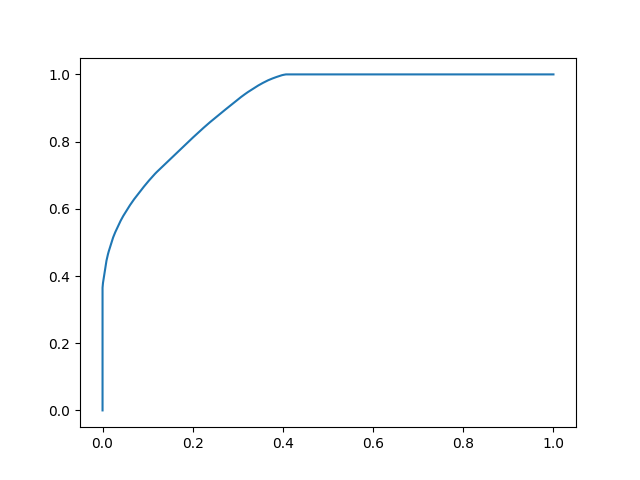

In [246]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Observation

Using only the `emp_title` field for training still achives good result in training, while model performs poorly in test set:

| Data| Accuracy | Precision | Recall | F1 |
|------|------|------|------|------|
|   Training Set  | 0.94    |0.94     |0.94  |0.92|
|   Test Set | 0.89    |0.24     |0.02  |0.03|


That suggestes the model performs very well on training data but has high error rates on test data, due to the model has
* high variance
* low bias